## Importing the libraries

In [1]:
import string
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import pymongo
pd.set_option("display.max_colwidth", None)

import tweepy
import preprocessor as p
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import preprocessor as p
from wordcloud import WordCloud
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Embedding, Bidirectional, TimeDistributed, Conv1D, SpatialDropout1D, AvgPool1D

## Extracting data from Twitter

In [2]:
# Entering credentials
log = pd.read_csv("./config/login.csv")
consumerKey         = log['consumerKey'][0]
consumerSecret      = log['consumerSecret'][0]
accessToken         = log['accessToken'][0]
accessTokenSecret   = log['accessTokenSecret'][0]

auth = tweepy.OAuthHandler(consumerKey, consumerSecret, accessToken, accessTokenSecret)
api = tweepy.API(auth)

print("-----------------------Access granted to Twitterr API-----------------------")

-----------------------Access granted to Twitterr API-----------------------


In [3]:
# Search parameters
searchTermInput = str(input("Enter a keyword to search for tweets which will be added to string 'covid19': "))
delta = int(input("Set the duration for extraction in days: "))

Enter a keyword to search for tweets which will be added to string 'covid19':  news
Set the duration for extraction in days: 8


In [4]:
# Getting the data from twitter
print("-----------------------Extracting data from Twitter-----------------------\n")
searchTerm = 'covid19 ' + searchTermInput
today = date.today()
startDate = today - timedelta(days = delta)
endDate = today + timedelta(days = 0)

temp = startDate
dateList = []
while(temp <= endDate):
    dateList.append(temp)
    temp = temp + timedelta(days = 1)


tweetsList = []
for date in dateList:
    
    sDate = date
    eDate = date + timedelta(days = 1)
    tweetCount = 0
    for page in tweepy.Cursor(api.search_tweets, q = f'{searchTerm} -filter:retweets since:{sDate} until:{eDate}',
                               lang = 'en', count = 100, tweet_mode = 'extended').pages(15):
        for tweet in page:

            tweetDate = tweet.created_at.date()
            tweetUsername = tweet.user.name
            tweetLocation = tweet.user.location
            tweetText = tweet.full_text.lower()
            
            tweetHashtags = []
            for hashtags in tweet.entities['hashtags']:
                tweetHashtags.append(str(hashtags['text']))
            
            tweetsList.append({'Date': tweetDate,
                              "User's Name": tweetUsername,
                              'Location': tweetLocation,
                              'Text': tweetText,
                              'Hashtags': tweetHashtags})

            tweetCount += 1
    
    totalTweets = len(tweetsList)
    
    print(f"Tweets extracted from {sDate} to {eDate}: {tweetCount}. Total Tweets: {totalTweets}")
            
print("\n-----------------------Data from Twitter extracted-----------------------\n")

tweetsDataset = pd.DataFrame(tweetsList, columns = ['Date', "User's Name", 'Location', 'Text', 'Hashtags'])
        
        
tweetsDataset

-----------------------Extracting data from Twitter-----------------------

Tweets extracted from 2022-05-05 to 2022-05-06: 838. Total Tweets: 838
Tweets extracted from 2022-05-06 to 2022-05-07: 1080. Total Tweets: 1918
Tweets extracted from 2022-05-07 to 2022-05-08: 561. Total Tweets: 2479
Tweets extracted from 2022-05-08 to 2022-05-09: 441. Total Tweets: 2920
Tweets extracted from 2022-05-09 to 2022-05-10: 846. Total Tweets: 3766
Tweets extracted from 2022-05-10 to 2022-05-11: 795. Total Tweets: 4561
Tweets extracted from 2022-05-11 to 2022-05-12: 872. Total Tweets: 5433
Tweets extracted from 2022-05-12 to 2022-05-13: 1103. Total Tweets: 6536
Tweets extracted from 2022-05-13 to 2022-05-14: 610. Total Tweets: 7146

-----------------------Data from Twitter extracted-----------------------



,Date,User's Name,Location,Text,Hashtags
0,2022-05-05,KHQA News,"Quincy, IL",#breaking: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/lpwkazxzsd,[BREAKING]
1,2022-05-05,13News Now,"Norfolk, VA",the changes in how we view and track covid-19 https://t.co/waz0h53dld,[]
2,2022-05-05,SparklyBon,,just in case you were wondering if there was a concerted effort to control where you get your news from.\nand that's just a hair's breadth away from controlling the information itself.\n#covid19 https://t.co/77gks7qgsl,[COVID19]
3,2022-05-05,Josh Namm,"Los Angeles, CA","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials https://t.co/lhlyejvgj8 #bluestates #covid19 #kids #news #schools","[BlueStates, Covid19, Kids, News, Schools]"
4,2022-05-05,WTVC NewsChannel 9,"Chattanooga, TN",breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/rxhnb8wenc,[]
...,...,...,...,...,...
7141,2022-05-13,UC Davis Health,"Sacramento, CA","a lot has changed during the #covid19 pandemic. chief wellness officer @peteryellowlees offers tips for navigating our “new normal,” including returning to work, managing loneliness, reconnecting with colleagues, and more: https://t.co/qgfzlpwdmn #mentalhealthawarenessmonth","[COVID19, MentalHealthAwarenessMonth]"
7142,2022-05-13,Bobbi-Jean MacKinnon,,#nb home-schooling more than doubles during #covid19 pandemic https://t.co/5p82w2e4k5 #education #parents #teachers https://t.co/vvtdcwjian,"[NB, COVID19, education, parents, teachers]"
7143,2022-05-13,ScoopUSA Media,"Philadelphia, PA",read: https://t.co/yhbnaauinh\n.\n.\n.\n.\n.\n#covid19 #maskmandate #blackmedia #localnews #community #scoop #news #africanamericans #philadelphia #scoopusamedia #philly #subscribe https://t.co/rtcafptokg,"[COVID19, maskmandate, blackmedia, localnews, community, scoop, news, africanamericans, philadelphia, scoopusamedia, philly, subscribe]"
7144,2022-05-13,ASU News,"Tempe, AZ","milestone: a massive effort to track the #covid19 pandemic in arizona over the past two years resulted in the genomic sequencing of more than 100,000 samples of the covid-19 virus by a coalition of arizona universities and health agencies.https://t.co/rh2r6bjcwa",[COVID19]


## Cleaning the Dataset

In [5]:
# Cleaning the texts
tweetsDataset['Cleaned Text'] = tweetsDataset['Text'].apply(lambda x: p.clean(x))

# Remove duplicate tweets
tweetsDataset.drop_duplicates(subset='Cleaned Text', keep = "first", inplace=True)

# Remove tweets with empty spaces
tweetsDataset['Cleaned Text'].replace('', np.nan, inplace = True)
tweetsDataset['Cleaned Text'].replace(' ', np.nan, inplace = True)
tweetsDataset.dropna(subset = ['Cleaned Text'], inplace = True)

# Tokenize the texts
tweetsDataset['Text Tokenized'] = tweetsDataset['Cleaned Text'].apply(lambda x: TreebankWordTokenizer().tokenize(x))

# Remove punctuations
def cleanPunctuation(tokens):
    newTokens = []
    punctuation = [i for i in string.punctuation]
    for word in tokens:
        if(word not in punctuation):
            newTokens.append(word)
    return newTokens
            
tweetsDataset['Text Tokenized'] = tweetsDataset['Text Tokenized'].apply(cleanPunctuation)

# Filter Out Stop Words
def removeStopWords(tokens):
    newTokens = []
    stopWords = stopwords.words('english')
    for word in tokens:
        if(word not in stopWords):
            newTokens.append(word)
    return newTokens

tweetsDataset['Text Tokenized'] = tweetsDataset['Text Tokenized'].apply(removeStopWords)

# Detokenize the clean text in a new column
def detokenize(tokens):
    text = []
    for word in tokens:
        text.append(TreebankWordDetokenizer().detokenize(word))
    return text
        
tweetsDataset['Text Detokenized'] = tweetsDataset['Text Tokenized'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

In [6]:
tweetsDataset

,Date,User's Name,Location,Text,Hashtags,Cleaned Text,Text Tokenized,Text Detokenized
0,2022-05-05,KHQA News,"Quincy, IL",#breaking: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/lpwkazxzsd,[BREAKING],: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.,"[u.s., regulators, today, strictly, limited, receive, johnson, amp, johnson, 's, covid-19, vaccine, ongoing, risk, rare, serious, blood, clots]",u.s. regulators today strictly limited receive johnson amp johnson's covid-19 vaccine ongoing risk rare serious blood clots
1,2022-05-05,13News Now,"Norfolk, VA",the changes in how we view and track covid-19 https://t.co/waz0h53dld,[],the changes in how we view and track covid-19,"[changes, view, track, covid-19]",changes view track covid-19
2,2022-05-05,SparklyBon,,just in case you were wondering if there was a concerted effort to control where you get your news from.\nand that's just a hair's breadth away from controlling the information itself.\n#covid19 https://t.co/77gks7qgsl,[COVID19],just in case you were wondering if there was a concerted effort to control where you get your news from. and that's just a hair's breadth away from controlling the information itself.,"[case, wondering, concerted, effort, control, get, news, from., 's, hair, 's, breadth, away, controlling, information]",case wondering concerted effort control get news from.'s hair's breadth away controlling information
3,2022-05-05,Josh Namm,"Los Angeles, CA","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials https://t.co/lhlyejvgj8 #bluestates #covid19 #kids #news #schools","[BlueStates, Covid19, Kids, News, Schools]","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials","[new, york, times, analysis, finds, school, closures, harmed, students, especially, major, cities, ‘which, tend, run, democratic, officials]",new york times analysis finds school closures harmed students especially major cities ‘which tend run democratic officials
4,2022-05-05,WTVC NewsChannel 9,"Chattanooga, TN",breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/rxhnb8wenc,[],breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.,"[breaking, u.s., regulators, thursday, strictly, limited, receive, johnson, amp, johnson, 's, covid-19, vaccine, due, ongoing, risk, rare, serious, blood, clots]",breaking u.s. regulators thursday strictly limited receive johnson amp johnson's covid-19 vaccine due ongoing risk rare serious blood clots
...,...,...,...,...,...,...,...,...
7141,2022-05-13,UC Davis Health,"Sacramento, CA","a lot has changed during the #covid19 pandemic. chief wellness officer @peteryellowlees offers tips for navigating our “new normal,” including returning to work, managing loneliness, reconnecting with colleagues, and more: https://t.co/qgfzlpwdmn #mentalhealthawarenessmonth","[COVID19, MentalHealthAwarenessMonth]","a lot has changed during the pandemic. chief wellness officer offers tips for navigating our “new normal,” including returning to work, managing loneliness, reconnecting with colleagues, and more:","[lot, changed, pandemic., chief, wellness, officer, offers, tips, navigating, “new, normal, ”, including, returning, work, managing, loneliness, reconnecting, colleagues]",lot changed pandemic. chief wellness officer offers tips navigating “new normal ” including returning work managing loneliness reconnecting colleagues
7142,2022-05-13,Bobbi-

In [7]:
# Uploading Data in the MongoDB server
client = pymongo.MongoClient("mongodb+srv://sa:ok@sentimentanalysis.hs59q.mongodb.net/myFirstDatabase?retryWrites=true&w=majority")
db = client.DB_SentimentTwitter

extract_datetime = datetime.today().strftime('%Y%m%d')
colName = 'tweet_' + extract_datetime

collist = db.list_collection_names()
if colName in collist:
      print("Collection already exists!")
else:
    newCol = db[colName]
    newColData = newCol.insert_many(json.loads(tweets_df.T.to_json()).values())

mgData = db[colName].find()
tweets_df= pd.DataFrame(list(mgData))

Collection already exists!


## Analysing the Dataset

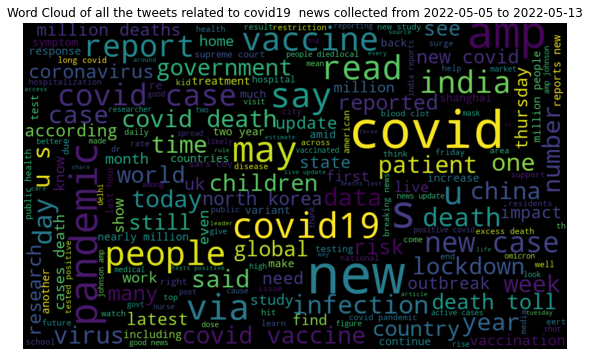

In [8]:
plt.figure(figsize = (10,6))
allWords = ' '.join([tweets for tweets in tweetsDataset['Text Detokenized']])
wordCould = WordCloud(width = 1000, height= 600, random_state=21, max_font_size=100).generate(allWords)

plt.imshow(wordCould, interpolation = "bilinear")
plt.axis('off')
plt.title(f"Word Cloud of all the tweets related to {searchTerm} collected from {startDate} to {endDate}")
plt.show()

In [9]:
# Using TextBlob to get the subjectivity and polarity of the text
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tweetsDataset['Subjectivity (TextBlob)'] = tweetsDataset['Text Detokenized'].apply(getSubjectivity)
tweetsDataset['Polarity (TextBlob)'] = tweetsDataset['Text Detokenized'].apply(getPolarity)

tweetsDataset

,Date,User's Name,Location,Text,Hashtags,Cleaned Text,Text Tokenized,Text Detokenized,Subjectivity (TextBlob),Polarity (TextBlob)
0,2022-05-05,KHQA News,"Quincy, IL",#breaking: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/lpwkazxzsd,[BREAKING],: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.,"[u.s., regulators, today, strictly, limited, receive, johnson, amp, johnson, 's, covid-19, vaccine, ongoing, risk, rare, serious, blood, clots]",u.s. regulators today strictly limited receive johnson amp johnson's covid-19 vaccine ongoing risk rare serious blood clots,0.569841,-0.034921
1,2022-05-05,13News Now,"Norfolk, VA",the changes in how we view and track covid-19 https://t.co/waz0h53dld,[],the changes in how we view and track covid-19,"[changes, view, track, covid-19]",changes view track covid-19,0.000000,0.000000
2,2022-05-05,SparklyBon,,just in case you were wondering if there was a concerted effort to control where you get your news from.\nand that's just a hair's breadth away from controlling the information itself.\n#covid19 https://t.co/77gks7qgsl,[COVID19],just in case you were wondering if there was a concerted effort to control where you get your news from. and that's just a hair's breadth away from controlling the information itself.,"[case, wondering, concerted, effort, control, get, news, from., 's, hair, 's, breadth, away, controlling, information]",case wondering concerted effort control get news from.'s hair's breadth away controlling information,0.000000,0.000000
3,2022-05-05,Josh Namm,"Los Angeles, CA","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials https://t.co/lhlyejvgj8 #bluestates #covid19 #kids #news #schools","[BlueStates, Covid19, Kids, News, Schools]","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials","[new, york, times, analysis, finds, school, closures, harmed, students, especially, major, cities, ‘which, tend, run, democratic, officials]",new york times analysis finds school closures harmed students especially major cities ‘which tend run democratic officials,0.727273,0.130682
4,2022-05-05,WTVC NewsChannel 9,"Chattanooga, TN",breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/rxhnb8wenc,[],breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.,"[breaking, u.s., regulators, thursday, strictly, limited, receive, johnson, amp, johnson, 's, covid-19, vaccine, due, ongoing, risk, rare, serious, blood, clots]",breaking u.s. regulators thursday strictly limited receive johnson amp johnson's covid-19 vaccine due ongoing risk rare serious blood clots,0.521131,-0.057440
...,...,...,...,...,...,...,...,...,...,...
7141,2022-05-13,UC Davis Health,"Sacramento, CA","a lot has changed during the #covid19 pandemic. chief wellness officer @peteryellowlees offers tips for navigating our “new normal,” including returning to work, managing loneliness, reconnecting with colleagues, and more: https://t.co/qgfzlpwdmn #mentalhealthawarenessmonth","[COVID19, MentalHealthAwarenessMonth]","a lot has changed during the pandemic. chief wellness officer offers tips for navigating our “new normal,” including returning to work, managing loneliness, reconnecting with colleagues, and more:","[lot, changed, pandemic., chief, wellness, officer, offers, tips, navigating, “new, normal, ”, including, returning, work, managing, loneliness, reconnecting, colleagues]",lot changed pandemic. chief w

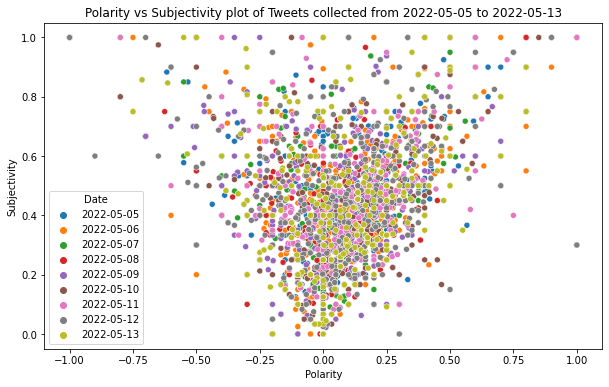

In [10]:
#Polarity vs Subjectivity Plot
plt.figure(figsize = (10, 6))
sns.scatterplot(x = tweetsDataset['Polarity (TextBlob)'],y = tweetsDataset['Subjectivity (TextBlob)'], hue = tweetsDataset['Date'])

plt.title(f'Polarity vs Subjectivity plot of Tweets collected from {startDate} to {endDate}')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [11]:
# Getting polarity scores from NLTK Vader
sia = SentimentIntensityAnalyzer()
tweetsDataset['Scores (NLTK Vader)'] = tweetsDataset['Text Detokenized'].apply(lambda x: sia.polarity_scores(x))
tweetsDataset['Compound Scores (NLTK Vader)'] = tweetsDataset['Scores (NLTK Vader)'].apply(lambda x: x['compound'])

# A function to assign labels to the tweets
def assignClass(x):
    if(x > 0.05):
        return 'Positive'
    elif(x <= 0.05 and x >= -0.05):
        return 'Neutral'
    else:
        return 'Negative'

# Assigning labels
tweetsDataset['Sentiment Class'] = tweetsDataset['Compound Scores (NLTK Vader)'].apply(assignClass)

tweetsDataset

,Date,User's Name,Location,Text,Hashtags,Cleaned Text,Text Tokenized,Text Detokenized,Subjectivity (TextBlob),Polarity (TextBlob),Scores (NLTK Vader),Compound Scores (NLTK Vader),Sentiment Class
0,2022-05-05,KHQA News,"Quincy, IL",#breaking: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/lpwkazxzsd,[BREAKING],: u.s. regulators today strictly limited who can receive johnson &amp; johnson's covid-19 vaccine because of the ongoing risk of rare but serious blood clots.,"[u.s., regulators, today, strictly, limited, receive, johnson, amp, johnson, 's, covid-19, vaccine, ongoing, risk, rare, serious, blood, clots]",u.s. regulators today strictly limited receive johnson amp johnson's covid-19 vaccine ongoing risk rare serious blood clots,0.569841,-0.034921,"{'neg': 0.275, 'neu': 0.725, 'pos': 0.0, 'compound': -0.5106}",-0.5106,Negative
1,2022-05-05,13News Now,"Norfolk, VA",the changes in how we view and track covid-19 https://t.co/waz0h53dld,[],the changes in how we view and track covid-19,"[changes, view, track, covid-19]",changes view track covid-19,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral
2,2022-05-05,SparklyBon,,just in case you were wondering if there was a concerted effort to control where you get your news from.\nand that's just a hair's breadth away from controlling the information itself.\n#covid19 https://t.co/77gks7qgsl,[COVID19],just in case you were wondering if there was a concerted effort to control where you get your news from. and that's just a hair's breadth away from controlling the information itself.,"[case, wondering, concerted, effort, control, get, news, from., 's, hair, 's, breadth, away, controlling, information]",case wondering concerted effort control get news from.'s hair's breadth away controlling information,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,Neutral
3,2022-05-05,Josh Namm,"Los Angeles, CA","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials https://t.co/lhlyejvgj8 #bluestates #covid19 #kids #news #schools","[BlueStates, Covid19, Kids, News, Schools]","new york times analysis finds school closures harmed students, especially in major cities ‘which tend to be run by democratic officials","[new, york, times, analysis, finds, school, closures, harmed, students, especially, major, cities, ‘which, tend, run, democratic, officials]",new york times analysis finds school closures harmed students especially major cities ‘which tend run democratic officials,0.727273,0.130682,"{'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4767}",-0.4767,Negative
4,2022-05-05,WTVC NewsChannel 9,"Chattanooga, TN",breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.\n\nhttps://t.co/rxhnb8wenc,[],breaking: u.s. regulators on thursday strictly limited who can receive johnson &amp; johnson's covid-19 vaccine due to the ongoing risk of rare but serious blood clots.,"[breaking, u.s., regulators, thursday, strictly, limited, receive, johnson, amp, johnson, 's, covid-19, vaccine, due, ongoing, risk, rare, serious, blood, clots]",breaking u.s. regulators thursday strictly limited receive johnson amp johnson's covid-19 vaccine due ongoing risk rare serious blood clots,0.521131,-0.057440,"{'neg': 0.249, 'neu': 0.751, 'pos': 0.0, 'compound': -0.5106}",-0.5106,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,2022-05-13,UC Davis Health,"Sacramento, CA","a lot has changed during the #covid19 pandemic. chief wellness officer @peteryellowlees offers tips for navigating our “new normal,” including returning to work, managing loneliness, reconnecting with colleagues, and more: https://t.co/qgfzlpwdmn #mentalh

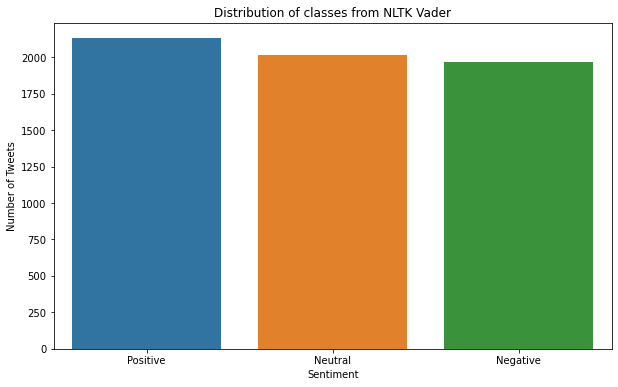

In [12]:
# Population distribution using bar graph
plt.figure(figsize = (10, 6))

x = tweetsDataset['Sentiment Class'].value_counts().index
y = tweetsDataset['Sentiment Class'].value_counts().values
sns.barplot(x = x, y = y)

plt.title('Distribution of classes from NLTK Vader')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

plt.show()

## Preparing the model for training

In [13]:
# Encoding the class labels
label_encoder = LabelEncoder()
label_encoder.fit(tweetsDataset['Sentiment Class'])
integerEncoded = label_encoder.transform(tweetsDataset['Sentiment Class'])
integerEncoded = integerEncoded.reshape(len(integerEncoded), 1)

onehot_encoder = OneHotEncoder(sparse = False)
y = onehot_encoder.fit_transform(integerEncoded)

In [14]:
# Dividing the dataset into Training, Validation and Test Set with 70:20:10 split
X_train, X_rem, y_train, y_rem = train_test_split(tweetsDataset['Text Detokenized'], y, random_state = 1, train_size = 0.7)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, random_state = 2, train_size = 2/3)

# Training the word2vec model for word embeddings
w2vModel = Word2Vec(min_count = 5, vector_size = 100)
corpus = tweetsDataset['Text Tokenized'].to_list()
w2vModel.build_vocab(corpus)
w2vModel.train(corpus, total_examples = len(corpus), epochs = 10)

# Converting the tweets into a padding sequence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.to_list())
wordIndex = tokenizer.word_index
vocabSize = len(wordIndex) + 1
print(f"Vocabulary Size: {vocabSize}")

# Keeping max. words in the sequence to be 40
maxlen = 40
sequencesTrain = tokenizer.texts_to_sequences(X_train)
sequencesValid = tokenizer.texts_to_sequences(X_valid)
sequencesTest = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(sequencesTrain, maxlen = maxlen)
X_valid = pad_sequences(sequencesValid, maxlen = maxlen)
X_test = pad_sequences(sequencesTest, maxlen = maxlen)

Vocabulary Size: 10781


In [15]:
# Dimension of each set
print(f"Dimension of X_train: {X_train.shape}")
print(f"Dimension of X_valid: {X_valid.shape}")
print(f"Dimension of X_test: {X_test.shape}")
print(f"Dimension of y_train: {y_train.shape}")
print(f"Dimension of y_valid: {y_valid.shape}")
print(f"Dimension of y_test: {y_test.shape}")

Dimension of X_train: (4281, 40)
Dimension of X_valid: (1223, 40)
Dimension of X_test: (612, 40)
Dimension of y_train: (4281, 3)
Dimension of y_valid: (1223, 3)
Dimension of y_test: (612, 3)


In [16]:
# Creating embedding matrix for the Embedding Layer
embeddingMatrix = np.zeros((vocabSize, 100))
for word, i in wordIndex.items():
    if word in w2vModel.wv:
        embeddingMatrix[i] = w2vModel.wv[word]
    
print(f"Embedding Matrix created using W2V Embeddings. Dimensions: {embeddingMatrix.shape}")

Embedding Matrix created using W2V Embeddings. Dimensions: (10781, 100)


## Building the model

### 1. LSTM Architecture

In [17]:
modelLSTM = Sequential()
modelLSTM.add(Embedding(input_dim = vocabSize, output_dim = 100, weights = [embeddingMatrix], input_length = 40, trainable = False))
modelLSTM.add(LSTM(20, return_sequences = True))
modelLSTM.add(LSTM(20, return_sequences = False))
modelLSTM.add(Dense(128, activation = 'relu'))
modelLSTM.add(Dense(3, activation = 'softmax'))


modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           1078100   
                                                                 
 lstm (LSTM)                 (None, 40, 20)            9680      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,094,135
Trainable params: 16,035
Non-trainable params: 1,078,100
_________________________________________________________________


In [18]:
modelLSTM.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyLSTM = modelLSTM.fit(X_train, y_train, batch_size = 8, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
536/536 [==============================] - 11s 12ms/step - loss: 1.0369 - accuracy: 0.4560 - val_loss: 0.9921 - val_accuracy: 0.4955
Epoch 2/20
536/536 [==============================] - 7s 13ms/step - loss: 0.9986 - accuracy: 0.5041 - val_loss: 0.9751 - val_accuracy: 0.5004
Epoch 3/20
536/536 [==============================] - 7s 13ms/step - loss: 0.9809 - accuracy: 0.5155 - val_loss: 0.9597 - val_accuracy: 0.5249
Epoch 4/20
536/536 [==============================] - 7s 13ms/step - loss: 0.9718 - accuracy: 0.5235 - val_loss: 0.9597 - val_accuracy: 0.5102
Epoch 5/20
536/536 [==============================] - 7s 13ms/step - loss: 0.9619 - accuracy: 0.5260 - val_loss: 0.9622 - val_accuracy: 0.5127
Epoch 6/20
536/536 [==============================] - 7s 13ms/step - loss: 0.9481 - accuracy: 0.5398 - val_loss: 0.9515 - val_accuracy: 0.5274
Epoch 7/20
536/536 [==============================] - 7s 13ms/step - loss: 0.9450 - accuracy: 0.5410 - val_loss: 0.9558 - val_accuracy: 0.527

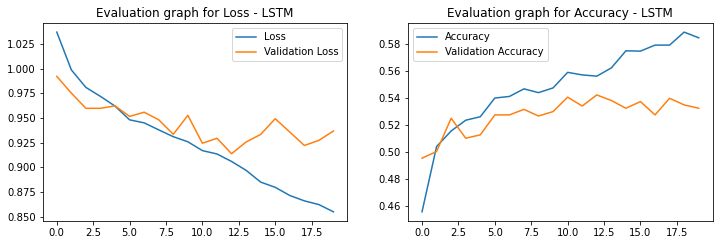

In [19]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyLSTM.history['loss'], label = 'Loss')
plt.plot(historyLSTM.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Evaluation graph for Loss - LSTM')

plt.subplot(2, 2, 2)
plt.plot(historyLSTM.history['accuracy'], label = 'Accuracy')
plt.plot(historyLSTM.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Evaluation graph for Accuracy - LSTM')

plt.show()

### 2. Adding Bidirectional LSTMs

In [20]:
modelBiLSTM = Sequential()

modelBiLSTM.add(Embedding(input_dim = vocabSize, output_dim = 100, weights = [embeddingMatrix], input_length = 40, trainable = False))
modelBiLSTM.add(Bidirectional(LSTM(20, dropout = 0.5, return_sequences = True)))
modelBiLSTM.add(Bidirectional(LSTM(20, return_sequences = False)))
modelBiLSTM.add(Dense(128, activation = 'relu'))
modelBiLSTM.add(Dense(3, activation = 'softmax'))


modelBiLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           1078100   
                                                                 
 bidirectional (Bidirectiona  (None, 40, 40)           19360     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               5248      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,112,855
Trainable params: 34,755
Non-t

In [21]:
modelBiLSTM.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyBiLSTM = modelBiLSTM.fit(X_train, y_train, batch_size = 8, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
536/536 [==============================] - 11s 14ms/step - loss: 1.0430 - accuracy: 0.4532 - val_loss: 1.0088 - val_accuracy: 0.4865
Epoch 2/20
536/536 [==============================] - 8s 15ms/step - loss: 1.0085 - accuracy: 0.4975 - val_loss: 1.0068 - val_accuracy: 0.4767
Epoch 3/20
536/536 [==============================] - 8s 15ms/step - loss: 0.9946 - accuracy: 0.5071 - val_loss: 0.9633 - val_accuracy: 0.5331
Epoch 4/20
536/536 [==============================] - 8s 15ms/step - loss: 0.9851 - accuracy: 0.5153 - val_loss: 0.9628 - val_accuracy: 0.5159
Epoch 5/20
536/536 [==============================] - 8s 15ms/step - loss: 0.9765 - accuracy: 0.5193 - val_loss: 0.9558 - val_accuracy: 0.5094
Epoch 6/20
536/536 [==============================] - 8s 14ms/step - loss: 0.9661 - accuracy: 0.5237 - val_loss: 0.9454 - val_accuracy: 0.5356
Epoch 7/20
536/536 [==============================] - 8s 15ms/step - loss: 0.9594 - accuracy: 0.5317 - val_loss: 0.9418 - val_accuracy: 0.524

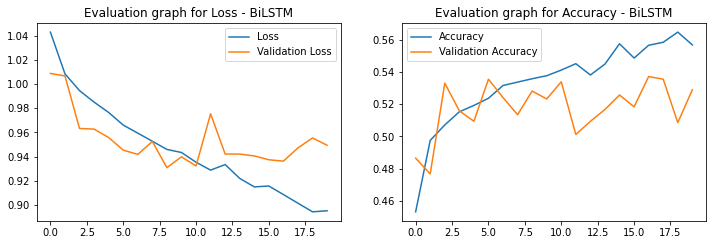

In [22]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyBiLSTM.history['loss'], label = 'Loss')
plt.plot(historyBiLSTM.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Evaluation graph for Loss - BiLSTM')

plt.subplot(2, 2, 2)
plt.plot(historyBiLSTM.history['accuracy'], label = 'Accuracy')
plt.plot(historyBiLSTM.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Evaluation graph for Accuracy - BiLSTM')

plt.show()

### 3. Using GRU Units

In [23]:
modelGruLSTM = Sequential()

modelGruLSTM.add(Embedding(input_dim = vocabSize, output_dim = 100, weights = [embeddingMatrix], input_length = 40, trainable = False))
modelGruLSTM.add(Bidirectional(GRU(20, dropout = 0.5, return_sequences = True)))
modelGruLSTM.add(Bidirectional(GRU(20, return_sequences = False)))
modelGruLSTM.add(Dense(128, activation = 'relu'))
modelGruLSTM.add(Dropout(0.5))
modelGruLSTM.add(Dense(3, activation = 'softmax'))


modelGruLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 100)           1078100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 40, 40)           14640     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               7440      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               5248      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [24]:
modelGruLSTM.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyGruLSTM = modelGruLSTM.fit(X_train, y_train, batch_size = 8, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
536/536 [==============================] - 12s 16ms/step - loss: 1.0774 - accuracy: 0.3948 - val_loss: 1.0032 - val_accuracy: 0.5037
Epoch 2/20
536/536 [==============================] - 10s 18ms/step - loss: 1.0274 - accuracy: 0.4812 - val_loss: 0.9735 - val_accuracy: 0.5070
Epoch 3/20
536/536 [==============================] - 9s 17ms/step - loss: 1.0030 - accuracy: 0.4971 - val_loss: 0.9698 - val_accuracy: 0.5143
Epoch 4/20
536/536 [==============================] - 9s 17ms/step - loss: 0.9937 - accuracy: 0.5127 - val_loss: 0.9844 - val_accuracy: 0.5070
Epoch 5/20
536/536 [==============================] - 9s 17ms/step - loss: 0.9835 - accuracy: 0.5146 - val_loss: 0.9814 - val_accuracy: 0.5143
Epoch 6/20
536/536 [==============================] - 9s 17ms/step - loss: 0.9800 - accuracy: 0.5176 - val_loss: 0.9465 - val_accuracy: 0.5159
Epoch 7/20
536/536 [==============================] - 9s 18ms/step - loss: 0.9706 - accuracy: 0.5237 - val_loss: 0.9442 - val_accuracy: 0.52

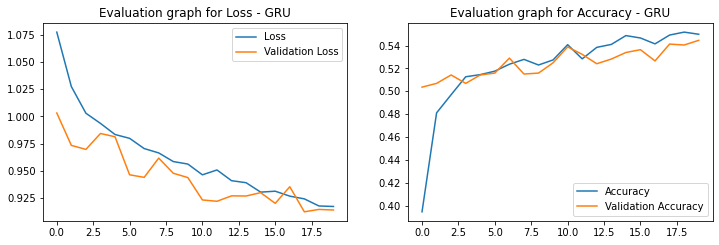

In [25]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyGruLSTM.history['loss'], label = 'Loss')
plt.plot(historyGruLSTM.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Evaluation graph for Loss - GRU')

plt.subplot(2, 2, 2)
plt.plot(historyGruLSTM.history['accuracy'], label = 'Accuracy')
plt.plot(historyGruLSTM.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Evaluation graph for Accuracy - GRU')

plt.show()

### 4. Adding Convolution Layers

In [26]:
modelCNN = Sequential()

modelCNN.add(Embedding(input_dim = vocabSize, output_dim = 100, weights = [embeddingMatrix], input_length = 40, trainable = False))
modelCNN.add(SpatialDropout1D(0.2))
modelCNN.add(Conv1D(40, 3, strides = 1, padding = 'valid', activation = 'relu'))
modelCNN.add(AvgPool1D(2, strides = 1))
modelCNN.add(Conv1D(20, 6, strides = 1))
modelCNN.add(Bidirectional(GRU(10, dropout = 0.5, return_sequences = True)))
modelCNN.add(Bidirectional(GRU(10, return_sequences = False)))
modelCNN.add(Dense(10, activation = 'relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(3, activation = 'softmax'))


modelCNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 100)           1078100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 40, 100)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 38, 40)            12040     
                                                                 
 average_pooling1d (AverageP  (None, 37, 40)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 20)            4820      
                                                                 
 bidirectional_4 (Bidirectio  (None, 32, 20)          

In [27]:
modelCNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
historyCNN = modelCNN.fit(X_train, y_train, batch_size = 8, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
536/536 [==============================] - 13s 16ms/step - loss: 1.0860 - accuracy: 0.3880 - val_loss: 1.0303 - val_accuracy: 0.4824
Epoch 2/20
536/536 [==============================] - 8s 14ms/step - loss: 1.0598 - accuracy: 0.4349 - val_loss: 1.0158 - val_accuracy: 0.4783
Epoch 3/20
536/536 [==============================] - 8s 15ms/step - loss: 1.0403 - accuracy: 0.4646 - val_loss: 1.0133 - val_accuracy: 0.5151
Epoch 4/20
536/536 [==============================] - 8s 15ms/step - loss: 1.0354 - accuracy: 0.4742 - val_loss: 0.9957 - val_accuracy: 0.5135
Epoch 5/20
536/536 [==============================] - 8s 15ms/step - loss: 1.0308 - accuracy: 0.4819 - val_loss: 1.0002 - val_accuracy: 0.4922
Epoch 6/20
536/536 [==============================] - 8s 15ms/step - loss: 1.0264 - accuracy: 0.4845 - val_loss: 0.9916 - val_accuracy: 0.5307
Epoch 7/20
536/536 [==============================] - 8s 14ms/step - loss: 1.0183 - accuracy: 0.4940 - val_loss: 0.9813 - val_accuracy: 0.516

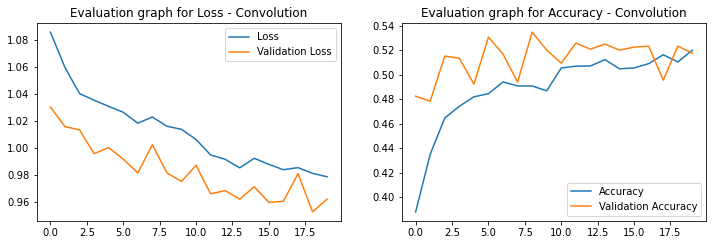

In [28]:
#Evaluation Graphs
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(historyCNN.history['loss'], label = 'Loss')
plt.plot(historyCNN.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Evaluation graph for Loss - Convolution')

plt.subplot(2, 2, 2)
plt.plot(historyCNN.history['accuracy'], label = 'Accuracy')
plt.plot(historyCNN.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Evaluation graph for Accuracy - Convolution')

plt.show()

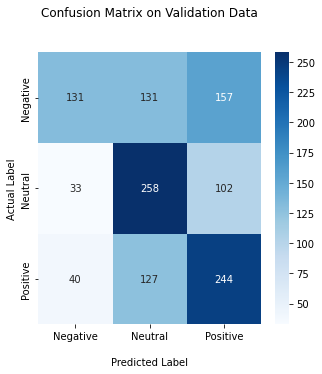


Classification Report on Validation Data



,0,1,2,accuracy,macro avg,weighted avg
precision,0.642157,0.500000,0.485089,0.51758,0.542415,0.543692
recall,0.312649,0.656489,0.593674,0.51758,0.520937,0.517580
f1-score,0.420546,0.567657,0.533917,0.51758,0.507373,0.505918
support,419.000000,393.000000,411.000000,0.51758,1223.000000,1223.000000


In [29]:
# Plotting Confusion Matrix and Classification report on Validation Data
predictionValid = modelCNN.predict(X_valid, steps = len(X_valid))
confusionMatrix = confusion_matrix(y_valid.argmax(axis = 1), predictionValid.argmax(axis = 1))

plt.figure(figsize = (5,5))
ax = sns.heatmap(confusionMatrix, annot = True, cmap = 'Blues', fmt = 'g')

ax.set_title('Confusion Matrix on Validation Data\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

plt.show()

print("\nClassification Report on Validation Data\n")
pd.DataFrame(classification_report(y_valid.argmax(axis = 1), predictionValid.argmax(axis = 1), output_dict=True))

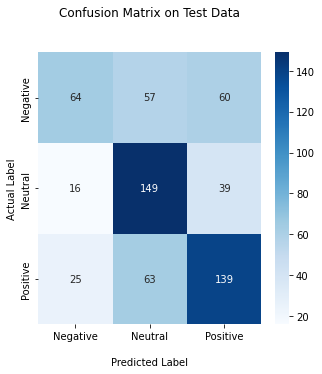


Classification Report on Test Data



,0,1,2,accuracy,macro avg,weighted avg
precision,0.609524,0.553903,0.584034,0.575163,0.582487,0.581529
recall,0.353591,0.730392,0.612335,0.575163,0.565439,0.575163
f1-score,0.447552,0.630021,0.597849,0.575163,0.558474,0.564123
support,181.000000,204.000000,227.000000,0.575163,612.000000,612.000000


In [30]:
# Plotting Confusion Matrix and Classification report on Test Data
predictionTest = modelCNN.predict(X_test, steps = len(X_test))
confusionMatrix = confusion_matrix(y_test.argmax(axis = 1), predictionTest.argmax(axis = 1))

plt.figure(figsize = (5,5))
ax = sns.heatmap(confusionMatrix, annot = True, cmap = 'Blues', fmt = 'g')

ax.set_title('Confusion Matrix on Test Data\n\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');

ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

plt.show()

print("\nClassification Report on Test Data\n")
pd.DataFrame(classification_report(y_test.argmax(axis = 1), predictionTest.argmax(axis = 1), output_dict=True))